# Problem Statement

In the fast-evolving landscape of the entertainment industry, it is important to gauge audience sentiments towards movie releases. Understanding the sentiments expressed in movie reviews is crucial for shaping marketing strategies, refining content creation, and ultimately enhancing the overall viewer experience. However, manually analyzing an extensive volume of reviews is time-consuming and may not capture nuanced sentiments at scale. To address this, we aim to develop an ML-based sentiment analyzer that automatically evaluates movie reviews, providing actionable insights into audience perceptions.

## Installing Libraries

In [4]:
import pandas as pd
pd.set_option('max_colwidth',None)
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re
import string
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score,classification_report,confusion_matrix,ConfusionMatrixDisplay

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/mohammadobeidat/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/mohammadobeidat/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [5]:
data=pd.read_csv('2.2+imdb_10K_sentimnets_reviews.csv')

In [6]:
data.head()

,review,sentiment
0,"Okay, I know this does'nt project India in a good light. But the overall theme of the movie is not India, it's Shakti. The power of a warlord, and the power of a mother. The relationship between Nandini and her husband and son swallow you up in their warmth. Then things go terribly wrong. The interaction between Nandini and her father in law - the power of their dysfunctional relationship - and the lives changed by it are the strengths of this movie. Shah Rukh Khan's performance seems to be a mere cameo compared to the believable desperation of Karisma Kapoor. It is easy to get caught up in the love, violence and redemption of lives in this film, and find yourself heaving a sigh of relief and sadness at the climax. The musical interludes are strengths, believable and well done.",1
1,"Despite John Travolta's statements in interviews that this was his favorite role of his career, ""Be Cool"" proves to be a disappointing sequel to 1995's witty and clever ""Get Shorty.""<br /><br />Travolta delivers a pleasant enough performance in this mildly entertaining film, but ultimately the movie falls flat due to an underdeveloped plot, unlikeable characters, and a surprising lack of chemistry between leads Travolta and Uma Thurman. Although there are some laughs, this unfunny dialog example (which appeared frequently in the trailers) kind of says it all: Thurman: Do you dance? Travolta: Hey, I'm from Brooklyn.<br /><br />The film suggests that everyone in the entertainment business is a gangster or aspires to be one, likening it to organized crime. In ""Get Shorty,"" the premise of a gangster ""going legitimate"" by getting into movies was a clever fish-out-of water idea, but in ""Be Cool,"" it seems the biz has entirely gone crooked since then.<br /><br />The film is interestingly casted and the absolute highlight is a ""monolgue"" delivered by The Rock, whose character is an aspiring actor as well as a goon, where he reenacts a scene between Gabrielle Union and Kirsten Dunst from ""Bring It On."" Vince Vaughan's character thinks he's black and he's often seen dressed as a pimp-- this was quite funny in the first scene that introduces him and gets tired and embarrassing almost immediately afterward.<br /><br />Overall, ""Be Cool"" may be worth a rental for John Travolta die-hards (of which I am one), but you may want to keep your finger close to the fast forward button to get through it without feeling that you wasted too much time. Fans of ""Get Shorty"" may actually wish to avoid this, as the sequel is devoid of most things that made that one a winner. I rate this movie an admittedly harsh 4/10.",0
2,"I am a kung fu fan, but not a Woo fan. I have no interest in gangster movies filled with over-the-top gun-play. Now, martial arts; *that's* beautiful! And John Woo surprised me here by producing a highly entertaining kung fu movie, which almost has *too much* fighting, if such a thing is possible! This is good stuff.<br /><br />Many of the fight scenes are very good (and some of them are less good), and the main characters are amusing and likable. The bad guys are a bit too unbelievably evil, but entertaining none the less. You gotta see the Sleeping Wizard!! He can only fight when he's asleep - it's hysterical!<br /><br />Upon repeated viewings, however, Last Hurrah For Chivalry can tend to get a little boring and long-winded, also especially because many of the fight scenes are actually not that good. Hence, I rate it ""only"" a 7 out of 10. But it really is almost an ""8"".<br /><br />All in all one of the better kung fu movies, made smack-dab in the heart of kung fu cinema's prime. All the really good kung fu movies are from the mid- to late 1970ies, with some notable exceptions from the late '60ies and early '70ies (and early '80ies, to be fair).",1
3,"He seems to be a control freak. I have heard him comment on ""losing control of the show"" and tell another guest who brought live animals that he had one rule-""n

In [7]:
data.shape

(10000, 2)

* we 10000 rows and 2 columns (Review and sentiment).

In [9]:
data.isnull().sum()

review       0
sentiment    0
dtype: int64

* There is no missing values in the data.

In [11]:
data.duplicated().sum()

18

* There is 18 duplicated rows.

In [13]:
data=data.drop_duplicates(keep='first')

In [14]:
data.shape

(9982, 2)

In [15]:
data=data.reset_index(drop=True)

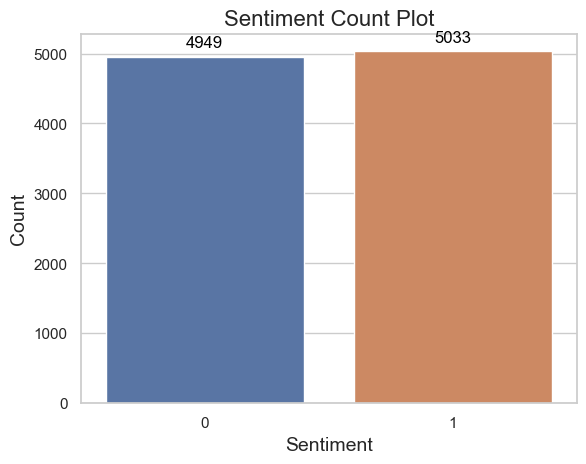

In [16]:
sns.set(style="whitegrid")
ax = sns.countplot(data=data, x='sentiment')

# Adding the count values on top of each bar
for p in ax.patches:
    ax.annotate(format(p.get_height(), '.0f'), 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha = 'center', va = 'center', 
                xytext = (0, 10), 
                textcoords = 'offset points',
                fontsize=12, color='black')

# Setting labels and title
ax.set_xlabel('Sentiment', fontsize=14)
ax.set_ylabel('Count', fontsize=14)
ax.set_title('Sentiment Count Plot', fontsize=16)

plt.show()

* Roughly half of sentiments are zero ,and the other half are one.

# Text preprocessing

## Removing special chareacters from the text.

In [20]:
def remove_special_characters(text):
    pattern='[^A-Za-z0-9]+'
    new_text=re.sub(pattern,' ',text)
    return new_text
    

In [21]:
data['cleaned_review']=data['review'].apply(remove_special_characters)

In [22]:
data.loc[0:5,['review','cleaned_review']]

,review,cleaned_review
0,"Okay, I know this does'nt project India in a good light. But the overall theme of the movie is not India, it's Shakti. The power of a warlord, and the power of a mother. The relationship between Nandini and her husband and son swallow you up in their warmth. Then things go terribly wrong. The interaction between Nandini and her father in law - the power of their dysfunctional relationship - and the lives changed by it are the strengths of this movie. Shah Rukh Khan's performance seems to be a mere cameo compared to the believable desperation of Karisma Kapoor. It is easy to get caught up in the love, violence and redemption of lives in this film, and find yourself heaving a sigh of relief and sadness at the climax. The musical interludes are strengths, believable and well done.",Okay I know this does nt project India in a good light But the overall theme of the movie is not India it s Shakti The power of a warlord and the power of a mother The relationship between Nandini and her husband and son swallow you up in their warmth Then things go terribly wrong The interaction between Nandini and her father in law the power of their dysfunctional relationship and the lives changed by it are the strengths of this movie Shah Rukh Khan s performance seems to be a mere cameo compared to the believable desperation of Karisma Kapoor It is easy to get caught up in the love violence and redemption of lives in this film and find yourself heaving a sigh of relief and sadness at the climax The musical interludes are strengths believable and well done
1,"Despite John Travolta's statements in interviews that this was his favorite role of his career, ""Be Cool"" proves to be a disappointing sequel to 1995's witty and clever ""Get Shorty.""<br /><br />Travolta delivers a pleasant enough performance in this mildly entertaining film, but ultimately the movie falls flat due to an underdeveloped plot, unlikeable characters, and a surprising lack of chemistry between leads Travolta and Uma Thurman. Although there are some laughs, this unfunny dialog example (which appeared frequently in the trailers) kind of says it all: Thurman: Do you dance? Travolta: Hey, I'm from Brooklyn.<br /><br />The film suggests that everyone in the entertainment business is a gangster or aspires to be one, likening it to organized crime. In ""Get Shorty,"" the premise of a gangster ""going legitimate"" by getting into movies was a clever fish-out-of water idea, but in ""Be Cool,"" it seems the biz has entirely gone crooked since then.<br /><br />The film is interestingly casted and the absolute highlight is a ""monolgue"" delivered by The Rock, whose character is an aspiring actor as well as a goon, where he reenacts a scene between Gabrielle Union and Kirsten Dunst from ""Bring It On."" Vince Vaughan's character thinks he's black and he's often seen dressed as a pimp-- this was quite funny in the first scene that introduces him and gets tired and embarrassing almost immediately afterward.<br /><br />Overall, ""Be Cool"" may be worth a rental for John Travolta die-hards (of which I am one), but you may want to keep your finger close to the fast forward button to get through it without feeling that you wasted too much time. Fans of ""Get Shorty"" may actually wish to avoid this, as the sequel is devoid of most things that made that one a winner. I rate this movie an admittedly harsh 4/10.",Despite John Travolta s statements in interviews that this was his favorite role of his career Be Cool proves to be a disappointing sequel to 1995 s witty and clever Get Shorty br br Travolta delivers a pleasant enough performance in this mildly entertaining film but ultimately the movie falls flat due to an underdeveloped plot unlikeable characters and a surprising lack of chemistry between leads Travolta and Uma Thurman Although there are some laughs this unfunny dialog example which appeared frequently in the trailers kind of says it all Thurman Do you dance Tra

* All non-alphanumeric character has been removed from original review column.

## Lowercasing

In [25]:
data['cleaned_review']=data['cleaned_review'].str.lower()
data.loc[0:5,['review','cleaned_review']]

,review,cleaned_review
0,"Okay, I know this does'nt project India in a good light. But the overall theme of the movie is not India, it's Shakti. The power of a warlord, and the power of a mother. The relationship between Nandini and her husband and son swallow you up in their warmth. Then things go terribly wrong. The interaction between Nandini and her father in law - the power of their dysfunctional relationship - and the lives changed by it are the strengths of this movie. Shah Rukh Khan's performance seems to be a mere cameo compared to the believable desperation of Karisma Kapoor. It is easy to get caught up in the love, violence and redemption of lives in this film, and find yourself heaving a sigh of relief and sadness at the climax. The musical interludes are strengths, believable and well done.",okay i know this does nt project india in a good light but the overall theme of the movie is not india it s shakti the power of a warlord and the power of a mother the relationship between nandini and her husband and son swallow you up in their warmth then things go terribly wrong the interaction between nandini and her father in law the power of their dysfunctional relationship and the lives changed by it are the strengths of this movie shah rukh khan s performance seems to be a mere cameo compared to the believable desperation of karisma kapoor it is easy to get caught up in the love violence and redemption of lives in this film and find yourself heaving a sigh of relief and sadness at the climax the musical interludes are strengths believable and well done
1,"Despite John Travolta's statements in interviews that this was his favorite role of his career, ""Be Cool"" proves to be a disappointing sequel to 1995's witty and clever ""Get Shorty.""<br /><br />Travolta delivers a pleasant enough performance in this mildly entertaining film, but ultimately the movie falls flat due to an underdeveloped plot, unlikeable characters, and a surprising lack of chemistry between leads Travolta and Uma Thurman. Although there are some laughs, this unfunny dialog example (which appeared frequently in the trailers) kind of says it all: Thurman: Do you dance? Travolta: Hey, I'm from Brooklyn.<br /><br />The film suggests that everyone in the entertainment business is a gangster or aspires to be one, likening it to organized crime. In ""Get Shorty,"" the premise of a gangster ""going legitimate"" by getting into movies was a clever fish-out-of water idea, but in ""Be Cool,"" it seems the biz has entirely gone crooked since then.<br /><br />The film is interestingly casted and the absolute highlight is a ""monolgue"" delivered by The Rock, whose character is an aspiring actor as well as a goon, where he reenacts a scene between Gabrielle Union and Kirsten Dunst from ""Bring It On."" Vince Vaughan's character thinks he's black and he's often seen dressed as a pimp-- this was quite funny in the first scene that introduces him and gets tired and embarrassing almost immediately afterward.<br /><br />Overall, ""Be Cool"" may be worth a rental for John Travolta die-hards (of which I am one), but you may want to keep your finger close to the fast forward button to get through it without feeling that you wasted too much time. Fans of ""Get Shorty"" may actually wish to avoid this, as the sequel is devoid of most things that made that one a winner. I rate this movie an admittedly harsh 4/10.",despite john travolta s statements in interviews that this was his favorite role of his career be cool proves to be a disappointing sequel to 1995 s witty and clever get shorty br br travolta delivers a pleasant enough performance in this mildly entertaining film but ultimately the movie falls flat due to an underdeveloped plot unlikeable characters and a surprising lack of chemistry between leads travolta and uma thurman although there are some laughs this unfunny dialog example which appeared frequently in the trailers kind of says it all thurman do you dance tra

## Removing extra white space

In [27]:
data['cleaned_review']=data['cleaned_review'].str.strip()
data.loc[0:3,['review','cleaned_review']]

,review,cleaned_review
0,"Okay, I know this does'nt project India in a good light. But the overall theme of the movie is not India, it's Shakti. The power of a warlord, and the power of a mother. The relationship between Nandini and her husband and son swallow you up in their warmth. Then things go terribly wrong. The interaction between Nandini and her father in law - the power of their dysfunctional relationship - and the lives changed by it are the strengths of this movie. Shah Rukh Khan's performance seems to be a mere cameo compared to the believable desperation of Karisma Kapoor. It is easy to get caught up in the love, violence and redemption of lives in this film, and find yourself heaving a sigh of relief and sadness at the climax. The musical interludes are strengths, believable and well done.",okay i know this does nt project india in a good light but the overall theme of the movie is not india it s shakti the power of a warlord and the power of a mother the relationship between nandini and her husband and son swallow you up in their warmth then things go terribly wrong the interaction between nandini and her father in law the power of their dysfunctional relationship and the lives changed by it are the strengths of this movie shah rukh khan s performance seems to be a mere cameo compared to the believable desperation of karisma kapoor it is easy to get caught up in the love violence and redemption of lives in this film and find yourself heaving a sigh of relief and sadness at the climax the musical interludes are strengths believable and well done
1,"Despite John Travolta's statements in interviews that this was his favorite role of his career, ""Be Cool"" proves to be a disappointing sequel to 1995's witty and clever ""Get Shorty.""<br /><br />Travolta delivers a pleasant enough performance in this mildly entertaining film, but ultimately the movie falls flat due to an underdeveloped plot, unlikeable characters, and a surprising lack of chemistry between leads Travolta and Uma Thurman. Although there are some laughs, this unfunny dialog example (which appeared frequently in the trailers) kind of says it all: Thurman: Do you dance? Travolta: Hey, I'm from Brooklyn.<br /><br />The film suggests that everyone in the entertainment business is a gangster or aspires to be one, likening it to organized crime. In ""Get Shorty,"" the premise of a gangster ""going legitimate"" by getting into movies was a clever fish-out-of water idea, but in ""Be Cool,"" it seems the biz has entirely gone crooked since then.<br /><br />The film is interestingly casted and the absolute highlight is a ""monolgue"" delivered by The Rock, whose character is an aspiring actor as well as a goon, where he reenacts a scene between Gabrielle Union and Kirsten Dunst from ""Bring It On."" Vince Vaughan's character thinks he's black and he's often seen dressed as a pimp-- this was quite funny in the first scene that introduces him and gets tired and embarrassing almost immediately afterward.<br /><br />Overall, ""Be Cool"" may be worth a rental for John Travolta die-hards (of which I am one), but you may want to keep your finger close to the fast forward button to get through it without feeling that you wasted too much time. Fans of ""Get Shorty"" may actually wish to avoid this, as the sequel is devoid of most things that made that one a winner. I rate this movie an admittedly harsh 4/10.",despite john travolta s statements in interviews that this was his favorite role of his career be cool proves to be a disappointing sequel to 1995 s witty and clever get shorty br br travolta delivers a pleasant enough performance in this mildly entertaining film but ultimately the movie falls flat due to an underdeveloped plot unlikeable characters and a surprising lack of chemistry between leads travolta and uma thurman although there are some laughs this unfunny dialog example which appeared frequently in the trailers kind of says it all thurman do you dance tra

## Removing stop words

In [29]:
def remove_stop_words(text):
    # Split text into separate words
    words = text.split()

    # Removing English language stopwords
    stop_words = set(stopwords.words('english'))  
    new_text = ' '.join([word for word in words if word not in stop_words])

    return new_text

In [30]:
data['cleaned_review'] = data['cleaned_review'].apply(remove_stop_words)

In [31]:
data.loc[0:3,['review','cleaned_review']]

,review,cleaned_review
0,"Okay, I know this does'nt project India in a good light. But the overall theme of the movie is not India, it's Shakti. The power of a warlord, and the power of a mother. The relationship between Nandini and her husband and son swallow you up in their warmth. Then things go terribly wrong. The interaction between Nandini and her father in law - the power of their dysfunctional relationship - and the lives changed by it are the strengths of this movie. Shah Rukh Khan's performance seems to be a mere cameo compared to the believable desperation of Karisma Kapoor. It is easy to get caught up in the love, violence and redemption of lives in this film, and find yourself heaving a sigh of relief and sadness at the climax. The musical interludes are strengths, believable and well done.",okay know nt project india good light overall theme movie india shakti power warlord power mother relationship nandini husband son swallow warmth things go terribly wrong interaction nandini father law power dysfunctional relationship lives changed strengths movie shah rukh khan performance seems mere cameo compared believable desperation karisma kapoor easy get caught love violence redemption lives film find heaving sigh relief sadness climax musical interludes strengths believable well done
1,"Despite John Travolta's statements in interviews that this was his favorite role of his career, ""Be Cool"" proves to be a disappointing sequel to 1995's witty and clever ""Get Shorty.""<br /><br />Travolta delivers a pleasant enough performance in this mildly entertaining film, but ultimately the movie falls flat due to an underdeveloped plot, unlikeable characters, and a surprising lack of chemistry between leads Travolta and Uma Thurman. Although there are some laughs, this unfunny dialog example (which appeared frequently in the trailers) kind of says it all: Thurman: Do you dance? Travolta: Hey, I'm from Brooklyn.<br /><br />The film suggests that everyone in the entertainment business is a gangster or aspires to be one, likening it to organized crime. In ""Get Shorty,"" the premise of a gangster ""going legitimate"" by getting into movies was a clever fish-out-of water idea, but in ""Be Cool,"" it seems the biz has entirely gone crooked since then.<br /><br />The film is interestingly casted and the absolute highlight is a ""monolgue"" delivered by The Rock, whose character is an aspiring actor as well as a goon, where he reenacts a scene between Gabrielle Union and Kirsten Dunst from ""Bring It On."" Vince Vaughan's character thinks he's black and he's often seen dressed as a pimp-- this was quite funny in the first scene that introduces him and gets tired and embarrassing almost immediately afterward.<br /><br />Overall, ""Be Cool"" may be worth a rental for John Travolta die-hards (of which I am one), but you may want to keep your finger close to the fast forward button to get through it without feeling that you wasted too much time. Fans of ""Get Shorty"" may actually wish to avoid this, as the sequel is devoid of most things that made that one a winner. I rate this movie an admittedly harsh 4/10.",despite john travolta statements interviews favorite role career cool proves disappointing sequel 1995 witty clever get shorty br br travolta delivers pleasant enough performance mildly entertaining film ultimately movie falls flat due underdeveloped plot unlikeable characters surprising lack chemistry leads travolta uma thurman although laughs unfunny dialog example appeared frequently trailers kind says thurman dance travolta hey brooklyn br br film suggests everyone entertainment business gangster aspires one likening organized crime get shorty premise gangster going legitimate getting movies clever fish water idea cool seems biz entirely gone crooked since br br film interestingly casted absolute highlight monolgue delivered rock whose character aspiring actor well goon reenacts scene gabrielle union kirsten dunst bring vince v

## Stemming

* The sentence "stemming" is the process of reducing words to their word stem, base or root form.

In [34]:
ps = PorterStemmer()
# defining a function to perform stemming
def stemmer(text):
    # Split text into separate words
    words = text.split()

    # Applying the Porter Stemmer on every word of a message and joining the stemmed words back into a single string
    new_text = ' '.join([ps.stem(word) for word in words])

    return new_text

In [35]:
def remove_stop_words(text):
    # Split text into separate words
    words = text.split()

    # Removing English language stopwords
    stop_words = set(stopwords.words('english'))  # Get the stop words for English
    new_text = ' '.join([word for word in words if word.lower() not in stop_words])

    return new_text

In [36]:
data['cleaned_review']=data['cleaned_review'].apply(stemmer)

In [37]:
data.loc[0:4,['review','cleaned_review']]

,review,cleaned_review
0,"Okay, I know this does'nt project India in a good light. But the overall theme of the movie is not India, it's Shakti. The power of a warlord, and the power of a mother. The relationship between Nandini and her husband and son swallow you up in their warmth. Then things go terribly wrong. The interaction between Nandini and her father in law - the power of their dysfunctional relationship - and the lives changed by it are the strengths of this movie. Shah Rukh Khan's performance seems to be a mere cameo compared to the believable desperation of Karisma Kapoor. It is easy to get caught up in the love, violence and redemption of lives in this film, and find yourself heaving a sigh of relief and sadness at the climax. The musical interludes are strengths, believable and well done.",okay know nt project india good light overal theme movi india shakti power warlord power mother relationship nandini husband son swallow warmth thing go terribl wrong interact nandini father law power dysfunct relationship live chang strength movi shah rukh khan perform seem mere cameo compar believ desper karisma kapoor easi get caught love violenc redempt live film find heav sigh relief sad climax music interlud strength believ well done
1,"Despite John Travolta's statements in interviews that this was his favorite role of his career, ""Be Cool"" proves to be a disappointing sequel to 1995's witty and clever ""Get Shorty.""<br /><br />Travolta delivers a pleasant enough performance in this mildly entertaining film, but ultimately the movie falls flat due to an underdeveloped plot, unlikeable characters, and a surprising lack of chemistry between leads Travolta and Uma Thurman. Although there are some laughs, this unfunny dialog example (which appeared frequently in the trailers) kind of says it all: Thurman: Do you dance? Travolta: Hey, I'm from Brooklyn.<br /><br />The film suggests that everyone in the entertainment business is a gangster or aspires to be one, likening it to organized crime. In ""Get Shorty,"" the premise of a gangster ""going legitimate"" by getting into movies was a clever fish-out-of water idea, but in ""Be Cool,"" it seems the biz has entirely gone crooked since then.<br /><br />The film is interestingly casted and the absolute highlight is a ""monolgue"" delivered by The Rock, whose character is an aspiring actor as well as a goon, where he reenacts a scene between Gabrielle Union and Kirsten Dunst from ""Bring It On."" Vince Vaughan's character thinks he's black and he's often seen dressed as a pimp-- this was quite funny in the first scene that introduces him and gets tired and embarrassing almost immediately afterward.<br /><br />Overall, ""Be Cool"" may be worth a rental for John Travolta die-hards (of which I am one), but you may want to keep your finger close to the fast forward button to get through it without feeling that you wasted too much time. Fans of ""Get Shorty"" may actually wish to avoid this, as the sequel is devoid of most things that made that one a winner. I rate this movie an admittedly harsh 4/10.",despit john travolta statement interview favorit role career cool prove disappoint sequel 1995 witti clever get shorti br br travolta deliv pleasant enough perform mildli entertain film ultim movi fall flat due underdevelop plot unlik charact surpris lack chemistri lead travolta uma thurman although laugh unfunni dialog exampl appear frequent trailer kind say thurman danc travolta hey brooklyn br br film suggest everyon entertain busi gangster aspir one liken organ crime get shorti premis gangster go legitim get movi clever fish water idea cool seem biz entir gone crook sinc br br film interestingli cast absolut highlight monolgu deliv rock whose charact aspir actor well goon reenact scene gabriel union kirsten dunst bring vinc vaughan charact think black often seen dress pimp quit funni first scene introduc get tire embarrass almost immedi afterward br br overal cool may worth rental

## Text vectorization

In [39]:
# Initializing CountVectorizer with top 1000 words
bow_vec = CountVectorizer(max_features=5000)

# Applying TfidfVectorizer on data
data_features_BOW = bow_vec.fit_transform(data['cleaned_review'])

# Convert the data features to array
data_features_BOW = data_features_BOW.toarray()

# Shape of the feature vector
data_features_BOW.shape

(9982, 5000)

In [40]:
# Getting the 1000 words considered by the BoW model
words = bow_vec.get_feature_names_out()

In [41]:
words

array(['00', '000', '10', ..., 'zombi', 'zone', 'zoom'], dtype=object)

## ML

In [43]:
# Creating a DataFrame from the data features
df_BOW = pd.DataFrame(data_features_BOW, columns=bow_vec.get_feature_names_out())
df_BOW.shape

(9982, 5000)

In [44]:
def confusion_matrix_sklearn(x,y):

    cm = confusion_matrix(x,y)
    print("Confusion Matrix:")
    print(cm)
    

In [45]:
X=df_BOW.copy()

In [46]:
y=data.sentiment

In [47]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 42)

In [48]:
# Building the model
rf_bow = RandomForestClassifier(n_estimators = 100, max_depth = 8, random_state = 42)

# Fitting on train data
rf_bow.fit(X_train, y_train)

RandomForestClassifier(max_depth=8, random_state=42)

In [49]:
# Predicting on train data
y_pred_train = rf_bow.predict(X_train)

# Predicting on test data
y_pred_test = rf_bow.predict(X_test)

Confusion Matrix:
[[3000  720]
 [ 246 3520]]


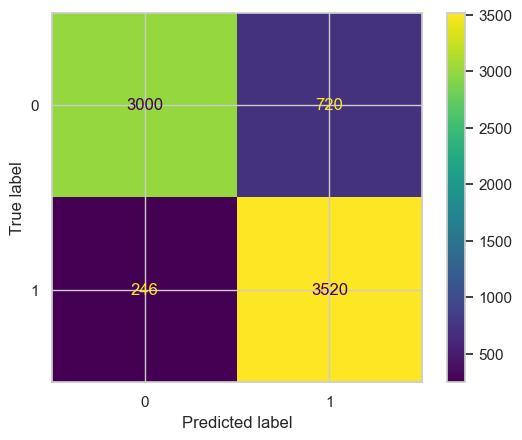

In [50]:
confusion_matrix_sklearn(y_train, y_pred_train)
classifier_05 = rf_bow.fit(X_train, y_train)
_ = ConfusionMatrixDisplay.from_estimator(classifier_05, X_train, y_train)


Confusion Matrix:
[[ 910  319]
 [ 140 1127]]


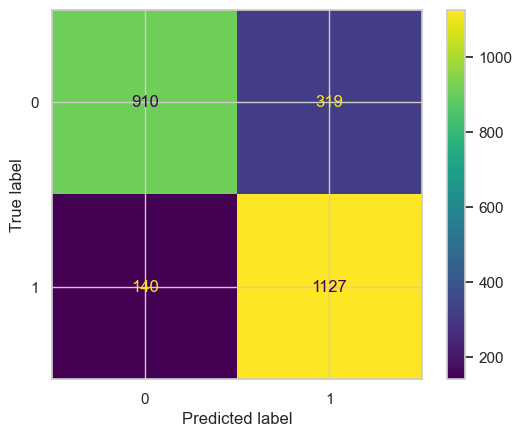

In [51]:
confusion_matrix_sklearn(y_test, y_pred_test)
classifier_05 = rf_bow.fit(X_train, y_train)
_ = ConfusionMatrixDisplay.from_estimator(classifier_05, X_test, y_test)

In [52]:
print(classification_report(y_train, y_pred_train))

              precision    recall  f1-score   support

           0       0.92      0.81      0.86      3720
           1       0.83      0.93      0.88      3766

    accuracy                           0.87      7486
   macro avg       0.88      0.87      0.87      7486
weighted avg       0.88      0.87      0.87      7486



In [53]:
print(classification_report(y_test, y_pred_test))

              precision    recall  f1-score   support

           0       0.87      0.74      0.80      1229
           1       0.78      0.89      0.83      1267

    accuracy                           0.82      2496
   macro avg       0.82      0.81      0.81      2496
weighted avg       0.82      0.82      0.81      2496



<font size=4 color='green'>After cleaning the review text and applying Bag-of-Words vectorization, the Random Forest model achieved an accuracy of 88% on the training data and 82% on the test data.</font>

<font size=6 color='red'>Farewell</font>


<font size=4 color='red'>Thank you for exploring this analysis with me! It has been a rewarding journey, and I appreciate your interest and engagement. I hope this notebook provided valuable insights and sparked some curiosity about machine learning and text analysis.
Until we meet again in the world of data science, farewell! Keep learning and exploring.</font>
